In [5]:
import os
from PIL import Image
import cv2
import numpy as np
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import display, Image as IPImage
import time
from skimage.metrics import structural_similarity as ssim

Этап 1

In [6]:
cells_path = 'blood_cells/cells'
background_path = 'blood_cells/background'
os.makedirs(cells_path, exist_ok=True)
os.makedirs(background_path, exist_ok=True)

In [7]:
# ПРЕДОБРАБОТКА ИЗОБРАЖЕНИЙ - приводим к одному размеру (64х64 / 128х128)
def resize_images(directory, size=(64, 64)):

    if not os.path.exists(directory):
        print(f"Директория {directory} не найдена.")
        return

    for filename in os.listdir(directory):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            file_path = os.path.join(directory, filename)
            try:
                with Image.open(file_path) as img:
                    img = img.resize(size, Image.LANCZOS)
                    img.save(file_path)
                    print(f"Изображение {filename} изменено на размер {size}.")
            except Exception as e:
                print(f"Ошибка при обработке файла {filename}: {e}")
resize_images(cells_path, size=(64, 64))  # 64x64
resize_images(background_path, size=(64, 64))  # 64x64

# resize_images('blood_cells/cells', size=(128, 128))  # 128x128


Изображение 1.png изменено на размер (64, 64).
Изображение 10.png изменено на размер (64, 64).
Изображение 2.png изменено на размер (64, 64).
Изображение 3.png изменено на размер (64, 64).
Изображение 4.png изменено на размер (64, 64).
Изображение 5.png изменено на размер (64, 64).
Изображение 6.png изменено на размер (64, 64).
Изображение 7.png изменено на размер (64, 64).
Изображение 8.png изменено на размер (64, 64).
Изображение 9.png изменено на размер (64, 64).
Изображение 1.png изменено на размер (64, 64).
Изображение 10.png изменено на размер (64, 64).
Изображение 2.png изменено на размер (64, 64).
Изображение 3.png изменено на размер (64, 64).
Изображение 4.png изменено на размер (64, 64).
Изображение 5.png изменено на размер (64, 64).
Изображение 6.png изменено на размер (64, 64).
Изображение 7.png изменено на размер (64, 64).
Изображение 8.png изменено на размер (64, 64).
Изображение 9.png изменено на размер (64, 64).


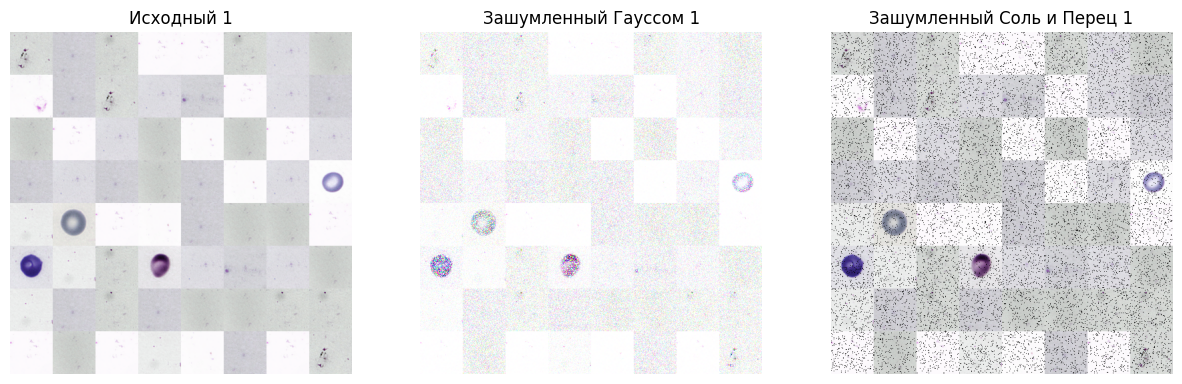

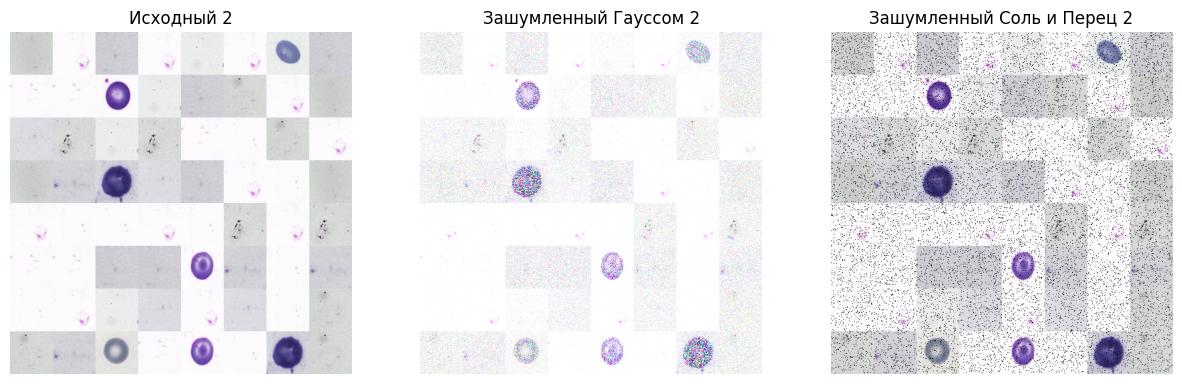

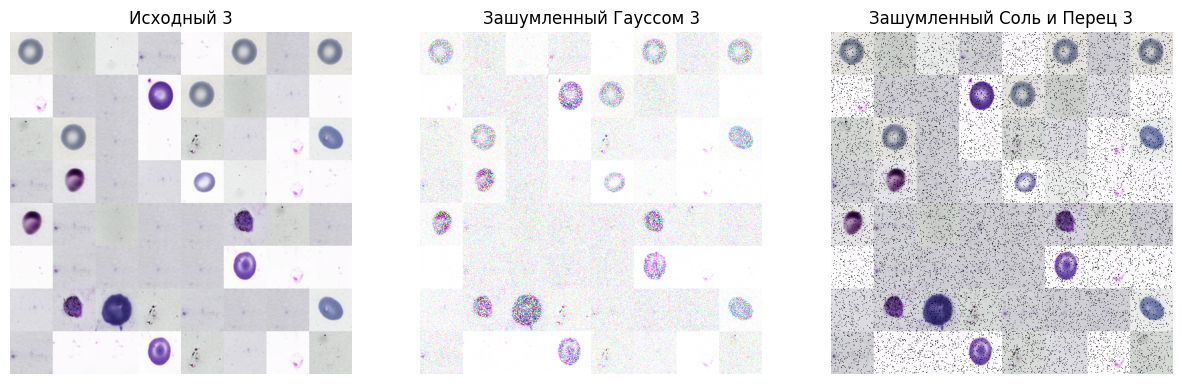

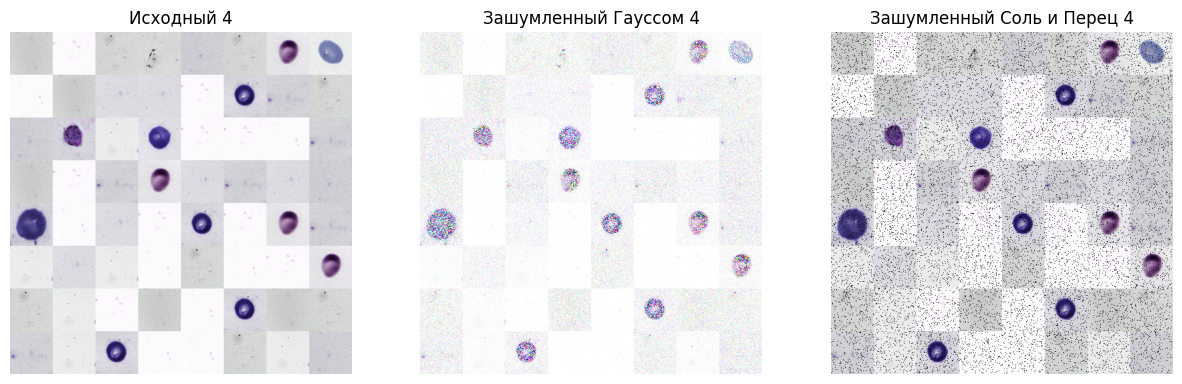

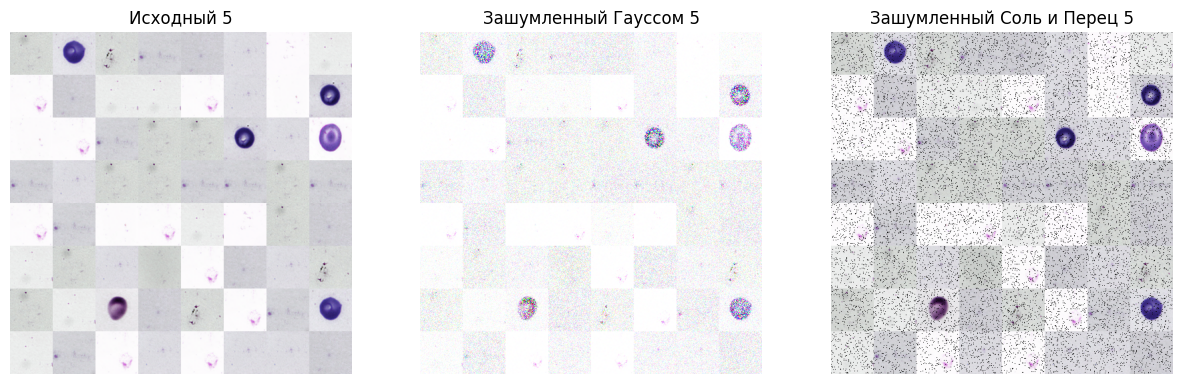

In [8]:
class BackgroundGenerator:
    def __init__(self, background_dir):
        self.background_images = [os.path.join(background_dir, img) for img in os.listdir(background_dir)]

    def get_random_background_patch(self):
        background_path = random.choice(self.background_images)
        return cv2.imread(background_path)

class CellGenerator:
    def __init__(self, cell_dir):
        self.cell_images = [os.path.join(cell_dir, img) for img in os.listdir(cell_dir)]

    def get_random_cell_patch(self):
        cell_path = random.choice(self.cell_images)
        return cv2.imread(cell_path)

class ImageGenerator:
    def __init__(self, background_generator, cell_generator, output_clear_dir, output_noise_dir, image_size=(8, 8)):
        self.background_generator = background_generator
        self.cell_generator = cell_generator
        self.output_clear_dir = output_clear_dir
        self.output_noise_dir = output_noise_dir
        self.image_size = image_size

    def generate_image(self):
        patch_size = 64 
        clear_image = np.zeros((patch_size * self.image_size[0], patch_size * self.image_size[1], 3), dtype=np.uint8)

        num_cells = random.randint(1, 16)
        positions = random.sample(range(self.image_size[0] * self.image_size[1]), num_cells)

        for pos in range(self.image_size[0] * self.image_size[1]):
            x = (pos % self.image_size[1]) * patch_size
            y = (pos // self.image_size[1]) * patch_size
            
            if pos in positions:
                cell_patch = self.cell_generator.get_random_cell_patch()
                cell_patch = cv2.resize(cell_patch, (patch_size, patch_size))
                clear_image[y:y + patch_size, x:x + patch_size] = cell_patch
            else:
                background_patch = self.background_generator.get_random_background_patch()
                background_patch = cv2.resize(background_patch, (patch_size, patch_size))
                clear_image[y:y + patch_size, x:x + patch_size] = background_patch

        return clear_image

    def add_noise_gaussian(self, image):
        noise = np.random.normal(0, 25, image.shape).astype(np.uint8)
        noisy_image = cv2.add(image, noise)
        return noisy_image
    
    def add_salt_and_pepper_noise(self, image, salt_prob=0.01, pepper_prob=0.01):
        noisy_image = np.copy(image)
        total_pixels = image.size
        num_salt = np.ceil(salt_prob * total_pixels)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
        noisy_image[coords[0], coords[1], :] = 1  # Salt

        num_pepper = np.ceil(pepper_prob * total_pixels)
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
        noisy_image[coords[0], coords[1], :] = 0  # Pepper
        return noisy_image


    def save_images(self, i):
        clear_image = self.generate_image()
        noisy_image_gaussian = self.add_noise_gaussian(clear_image)
        noisy_image_sp = self.add_salt_and_pepper_noise(clear_image)

        clear_filename = os.path.join(self.output_clear_dir, f'clear_image_{i}.png')
        noise_filename_gaussian = os.path.join(self.output_noise_dir, f'noisy_image_gaussian_{i}.png')
        noise_filename_sp = os.path.join(self.output_noise_dir, f'noisy_image_sp_{i}.png')

        cv2.imwrite(clear_filename, clear_image)
        cv2.imwrite(noise_filename_gaussian, noisy_image_gaussian)
        cv2.imwrite(noise_filename_sp, noisy_image_sp)

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(clear_image, cv2.COLOR_BGR2RGB))
        plt.title(f'Исходный {i}')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(noisy_image_gaussian, cv2.COLOR_BGR2RGB))
        plt.title(f'Зашумленный Гауссом {i}')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(noisy_image_sp, cv2.COLOR_BGR2RGB))
        plt.title(f'Зашумленный Соль и Перец {i}')
        plt.axis('off')

        plt.show()

background_gen = BackgroundGenerator('blood_cells/background')
cell_gen = CellGenerator('blood_cells/cells')
output_clear_dir = 'blood_cells/dataset/clear'
output_noise_dir = 'blood_cells/dataset/noise'

os.makedirs(output_clear_dir, exist_ok=True)
os.makedirs(output_noise_dir, exist_ok=True)

image_gen = ImageGenerator(background_gen, cell_gen, output_clear_dir, output_noise_dir)

num_images_to_generate = 5 
for i in range(1, num_images_to_generate + 1):
    image_gen.save_images(i)


ЭТАП 2

In [9]:
def mse(image1, image2):
    return np.mean((image1 - image2) ** 2)

def calculate_ssim(image1, image2):
    if image1.shape != image2.shape:
        raise ValueError("Изображения должны иметь одинаковый размер")
    min_side = min(image1.shape[:2])
    win_size = min(7, min_side)
    if win_size % 2 == 0:
        win_size -= 1
    return ssim(image1, image2, win_size=win_size, channel_axis=-1)

def apply_median_filter(image, kernel_size=3):
    return cv2.medianBlur(image, kernel_size)

def apply_gaussian_filter(image, kernel_size=(5, 5), sigma=0):
    return cv2.GaussianBlur(image, kernel_size, sigma)

def apply_bilateral_filter(image, d=9, sigma_color=75, sigma_space=75):
    return cv2.bilateralFilter(image, d, sigma_color, sigma_space)

def apply_non_local_means_filter(image, h=10, template_window_size=7, search_window_size=21):
    return cv2.fastNlMeansDenoisingColored(image, None, h, h, template_window_size, search_window_size)


def custom_denoise_cpu(image, kernel_size=3):
    pad = kernel_size // 2
    padded_image = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REFLECT)
    output = np.zeros_like(image)
    
    for i in range(pad, padded_image.shape[0] - pad):
        for j in range(pad, padded_image.shape[1] - pad):
            patch = padded_image[i-pad:i+pad+1, j-pad:j+pad+1]
            output[i-pad, j-pad] = np.mean(patch, axis=(0, 1))
    
    return output


In [10]:
# Функция для оценки фильтров
def evaluate_filters(clear_image, noisy_image):
    results = {}
    
    # Медианный фильтр
    start_time = time.time()
    median_filtered = apply_median_filter(noisy_image)
    median_time = time.time() - start_time
    results['median'] = {
        'mse': mse(clear_image, median_filtered),
        'ssim': calculate_ssim(clear_image, median_filtered),
        'time': median_time
    }
    
    # Гауссовский фильтр
    start_time = time.time()
    gaussian_filtered = apply_gaussian_filter(noisy_image)
    gaussian_time = time.time() - start_time
    results['gaussian'] = {
        'mse': mse(clear_image, gaussian_filtered),
        'ssim': calculate_ssim(clear_image, gaussian_filtered),
        'time': gaussian_time
    }
    
    # Билатеральный фильтр
    start_time = time.time()
    bilateral_filtered = apply_bilateral_filter(noisy_image)
    bilateral_time = time.time() - start_time
    results['bilateral'] = {
        'mse': mse(clear_image, bilateral_filtered),
        'ssim': calculate_ssim(clear_image, bilateral_filtered),
        'time': bilateral_time
    }
    
    # Фильтр нелокальных средних
    start_time = time.time()
    non_local_means_filtered = apply_non_local_means_filter(noisy_image)
    non_local_means_time = time.time() - start_time
    results['non_local_means'] = {
        'mse': mse(clear_image, non_local_means_filtered),
        'ssim': calculate_ssim(clear_image, non_local_means_filtered),
        'time': non_local_means_time
    }
    
    # Самостоятельная реализация (CPU)
    start_time = time.time()
    custom_cpu_filtered = custom_denoise_cpu(noisy_image)
    custom_cpu_time = time.time() - start_time
    results['custom_cpu'] = {
        'mse': mse(clear_image, custom_cpu_filtered),
        'ssim': calculate_ssim(clear_image, custom_cpu_filtered),
        'time': custom_cpu_time
    }
    
    return results

In [14]:
all_results = {}

for i in range(1, num_images_to_generate + 1):
    clear_image = cv2.imread(os.path.join(output_clear_dir, f'clear_image_{i}.png'))
    noisy_image_gaussian = cv2.imread(os.path.join(output_noise_dir, f'noisy_image_gaussian_{i}.png'))
    noisy_image_sp = cv2.imread(os.path.join(output_noise_dir, f'noisy_image_sp_{i}.png'))
    
    results_gaussian = evaluate_filters(clear_image, noisy_image_gaussian)
    results_sp = evaluate_filters(clear_image, noisy_image_sp)
    
    all_results[f'image_{i}'] = {
        'gaussian': results_gaussian,
        'salt_and_pepper': results_sp
    }

    print(f"Results for image {i} with Gaussian noise:")
    print(results_gaussian)
    
    print(f"Results for image {i} with Salt and Pepper noise:")
    print(results_sp)

Results for image 1 with Gaussian noise:
{'median': {'mse': np.float64(93.57687250773112), 'ssim': np.float64(0.5474503204337776), 'time': 0.0004410743713378906}, 'gaussian': {'mse': np.float64(89.91961415608723), 'ssim': np.float64(0.7662513871401325), 'time': 0.0005860328674316406}, 'bilateral': {'mse': np.float64(89.76628239949544), 'ssim': np.float64(0.7830316003263481), 'time': 0.005703926086425781}, 'non_local_means': {'mse': np.float64(86.9044189453125), 'ssim': np.float64(0.7989163088805827), 'time': 1.2096035480499268}, 'custom_cpu': {'mse': np.float64(90.29633331298828), 'ssim': np.float64(0.7240957219497979), 'time': 3.0949854850769043}}
Results for image 1 with Salt and Pepper noise:
{'median': {'mse': np.float64(4.4133656819661455), 'ssim': np.float64(0.9454764061454384), 'time': 0.0007727146148681641}, 'gaussian': {'mse': np.float64(63.22662226359049), 'ssim': np.float64(0.36598872438474334), 'time': 0.0003991127014160156}, 'bilateral': {'mse': np.float64(14.3356806437174

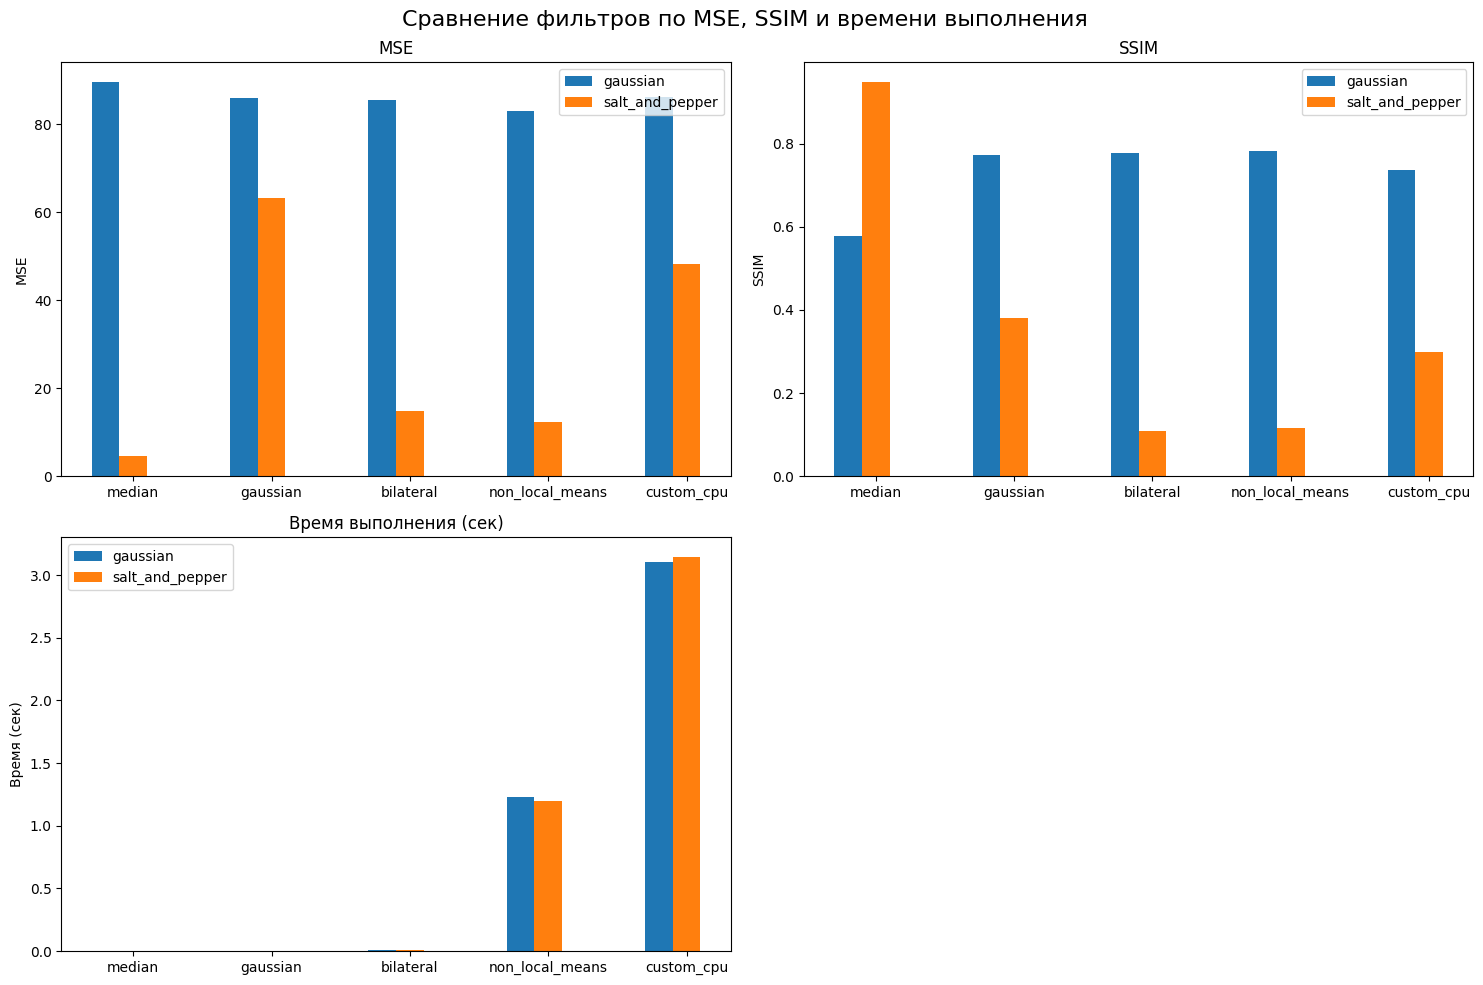

In [ ]:
def plot_results(all_results):
    filters = ['median', 'gaussian', 'bilateral', 'non_local_means', 'custom_cpu']
    noise_types = ['gaussian', 'salt_and_pepper']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle("Сравнение фильтров по MSE, SSIM и времени выполнения", fontsize=16)
    
    # График для MSE
    for i, noise_type in enumerate(noise_types):
        mse_values = [
            np.mean([all_results[image][noise_type][filter_]['mse'] for image in all_results])  # Преобразуем генератор в список
            for filter_ in filters
        ]
        axes[0, 0].bar(np.arange(len(filters)) + i * 0.2, mse_values, width=0.2, label=noise_type)
    axes[0, 0].set_title("MSE")
    axes[0, 0].set_xticks(np.arange(len(filters)) + 0.2)
    axes[0, 0].set_xticklabels(filters)
    axes[0, 0].set_ylabel("MSE")
    axes[0, 0].legend()
    
    # График для SSIM
    for i, noise_type in enumerate(noise_types):
        ssim_values = [
            np.mean([all_results[image][noise_type][filter_]['ssim'] for image in all_results])  # Преобразуем генератор в список
            for filter_ in filters
        ]
        axes[0, 1].bar(np.arange(len(filters)) + i * 0.2, ssim_values, width=0.2, label=noise_type)
    axes[0, 1].set_title("SSIM")
    axes[0, 1].set_xticks(np.arange(len(filters)) + 0.2)
    axes[0, 1].set_xticklabels(filters)
    axes[0, 1].set_ylabel("SSIM")
    axes[0, 1].legend()
    
    # График для времени выполнения
    for i, noise_type in enumerate(noise_types):
        time_values = [
            np.mean([all_results[image][noise_type][filter_]['time'] for image in all_results])  # Преобразуем генератор в список
            for filter_ in filters
        ]
        axes[1, 0].bar(np.arange(len(filters)) + i * 0.2, time_values, width=0.2, label=noise_type)
    axes[1, 0].set_title("Время выполнения (сек)")
    axes[1, 0].set_xticks(np.arange(len(filters)) + 0.2)
    axes[1, 0].set_xticklabels(filters)
    axes[1, 0].set_ylabel("Время (сек)")
    axes[1, 0].legend()
    
    fig.delaxes(axes[1, 1])
    
    plt.tight_layout()
    plt.show()

plot_results(all_results)